https://dacon.io/competitions/open/235539/codeshare/6862?page=1&dtype=recent[타이타닉 생존예측, with PCA](https://dacon.io/competitions/open/235539/codeshare/6862?page=1&dtype=recent)

In [5]:
# 행렬 연산 관련
import pandas as pd
import numpy as np

# 데이터 시각화 관련
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style = 'white', context = 'notebook', palette = 'deep')

# 경고 무시
import warnings
warnings.filterwarnings('ignore')

# 파일 입출력 관련. 제출 파일 만들때 씀
import glob
import os
# 정규식
import re

import statsmodels.api as sm
from sklearn import preprocessing

# 이미 구현된 인공지능 분류 모델, 학습 기법들
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC


from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/gdrive')
#설정한 디렉토리에 따라 "/KISIA/Data/" 파트를 조정한다.
#애매하면 "/content/gdrive/My Drive/" 루트에 저장한다.
colab_path = "/content/gdrive/My Drive/KISIA/Data/"

Mounted at /content/gdrive


In [6]:
df_train = pd.read_csv(colab_path + 'titanic/titanic_train.csv')
df_test = pd.read_csv(colab_path + 'titanic/titanic_test.csv')
df_val = pd.read_csv(colab_path + '/titanic/titanic_gender_submission.csv')

In [7]:
df_test['Survived'] = df_val['Survived'] # 데이터 합치기

In [9]:
df_train['Age'] = df_train['Age'].fillna(df_train['Age'].mean()) # 결측치 채우기
df_train=df_train.drop(['Cabin', 'Ticket','Name'],axis = 1) # 불필요한 데이터 삭제
df_train= df_train.dropna(axis=0, subset=['Embarked'])  # 결측치가 있는 행 삭제
df_train.fillna(0, inplace=True) # 결측치 채우기

In [10]:
df_train['Sex'] = df_train['Sex'].astype('category') # 데이터 타입 변경
df_train['Sex'].value_counts() # 데이터 확인

,count
Sex,
male,577
female,312


In [11]:
df_train['Embarked'] = df_train['Embarked'].astype('category') # 데이터 타입 변경
df_train['Embarked'].value_counts() # 데이터 확인

,count
Embarked,
S,644
C,168
Q,77


In [12]:
df_test.isnull().sum() # 결측치 확인

,0
PassengerId,0
Pclass,0
Name,0
Sex,0
Age,86
SibSp,0
Parch,0
Ticket,0
Fare,1
Cabin,327


In [14]:
df_test['Age'] = df_test['Age'].fillna(df_test['Age'].mean()) # 결측치 채우기
df_test=df_test.drop(['Cabin','Ticket'],axis = 1) # 불필요한 데이터 삭제
df_test.fillna(0, inplace=True) # 결측치 채우기

In [15]:
df_test['Sex'].value_counts() # 데이터 확인

,count
Sex,
male,266
female,152


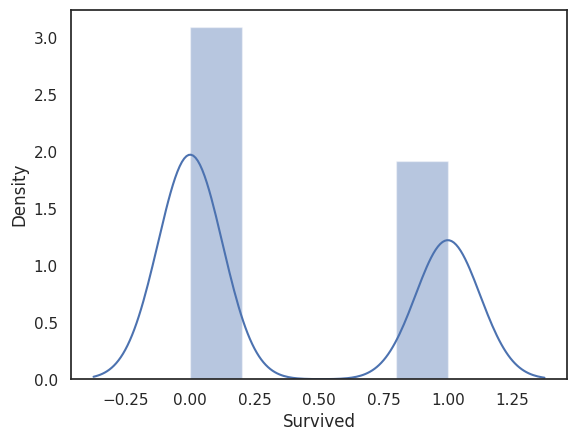

In [16]:
sns.distplot(df_train['Survived']) # 데이터 분포 확인
plt.show()

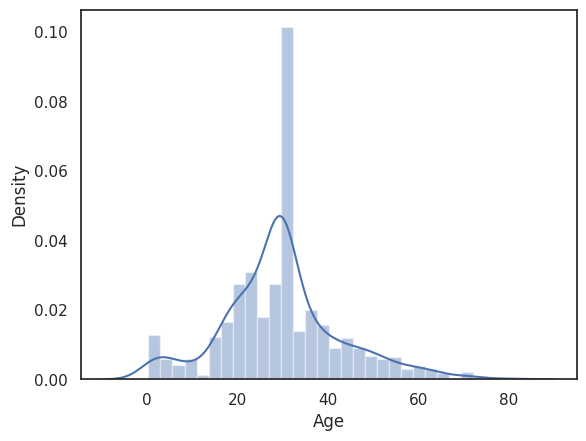

In [17]:
sns.distplot(df_train['Age']) # 데이터 분포 확인
plt.show()

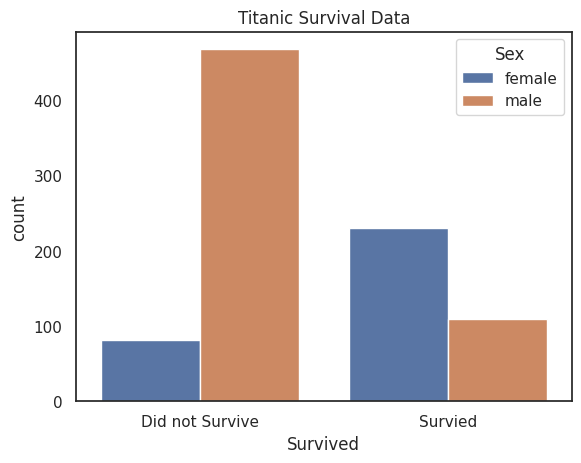

In [18]:
sns.countplot(data=df_train, x = 'Survived', hue='Sex').set(xticklabels = ['Did not Survive', 'Survied'], title = 'Titanic Survival Data') # 데이터 분포 확인
plt.show()

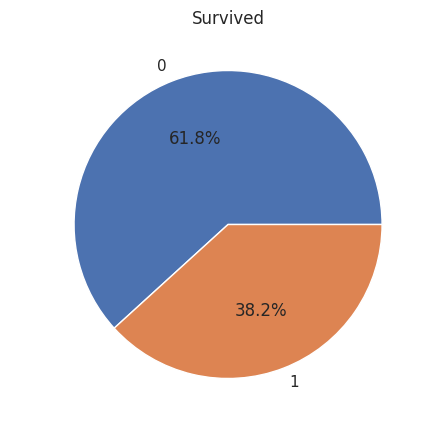

In [19]:
fig = plt.figure(figsize=(5,5))
df_train['Survived'].value_counts().plot(kind = 'pie', autopct='%.1f%%')
plt.ylabel(" ", fontsize = 15)
plt.title("Survived")
print("")

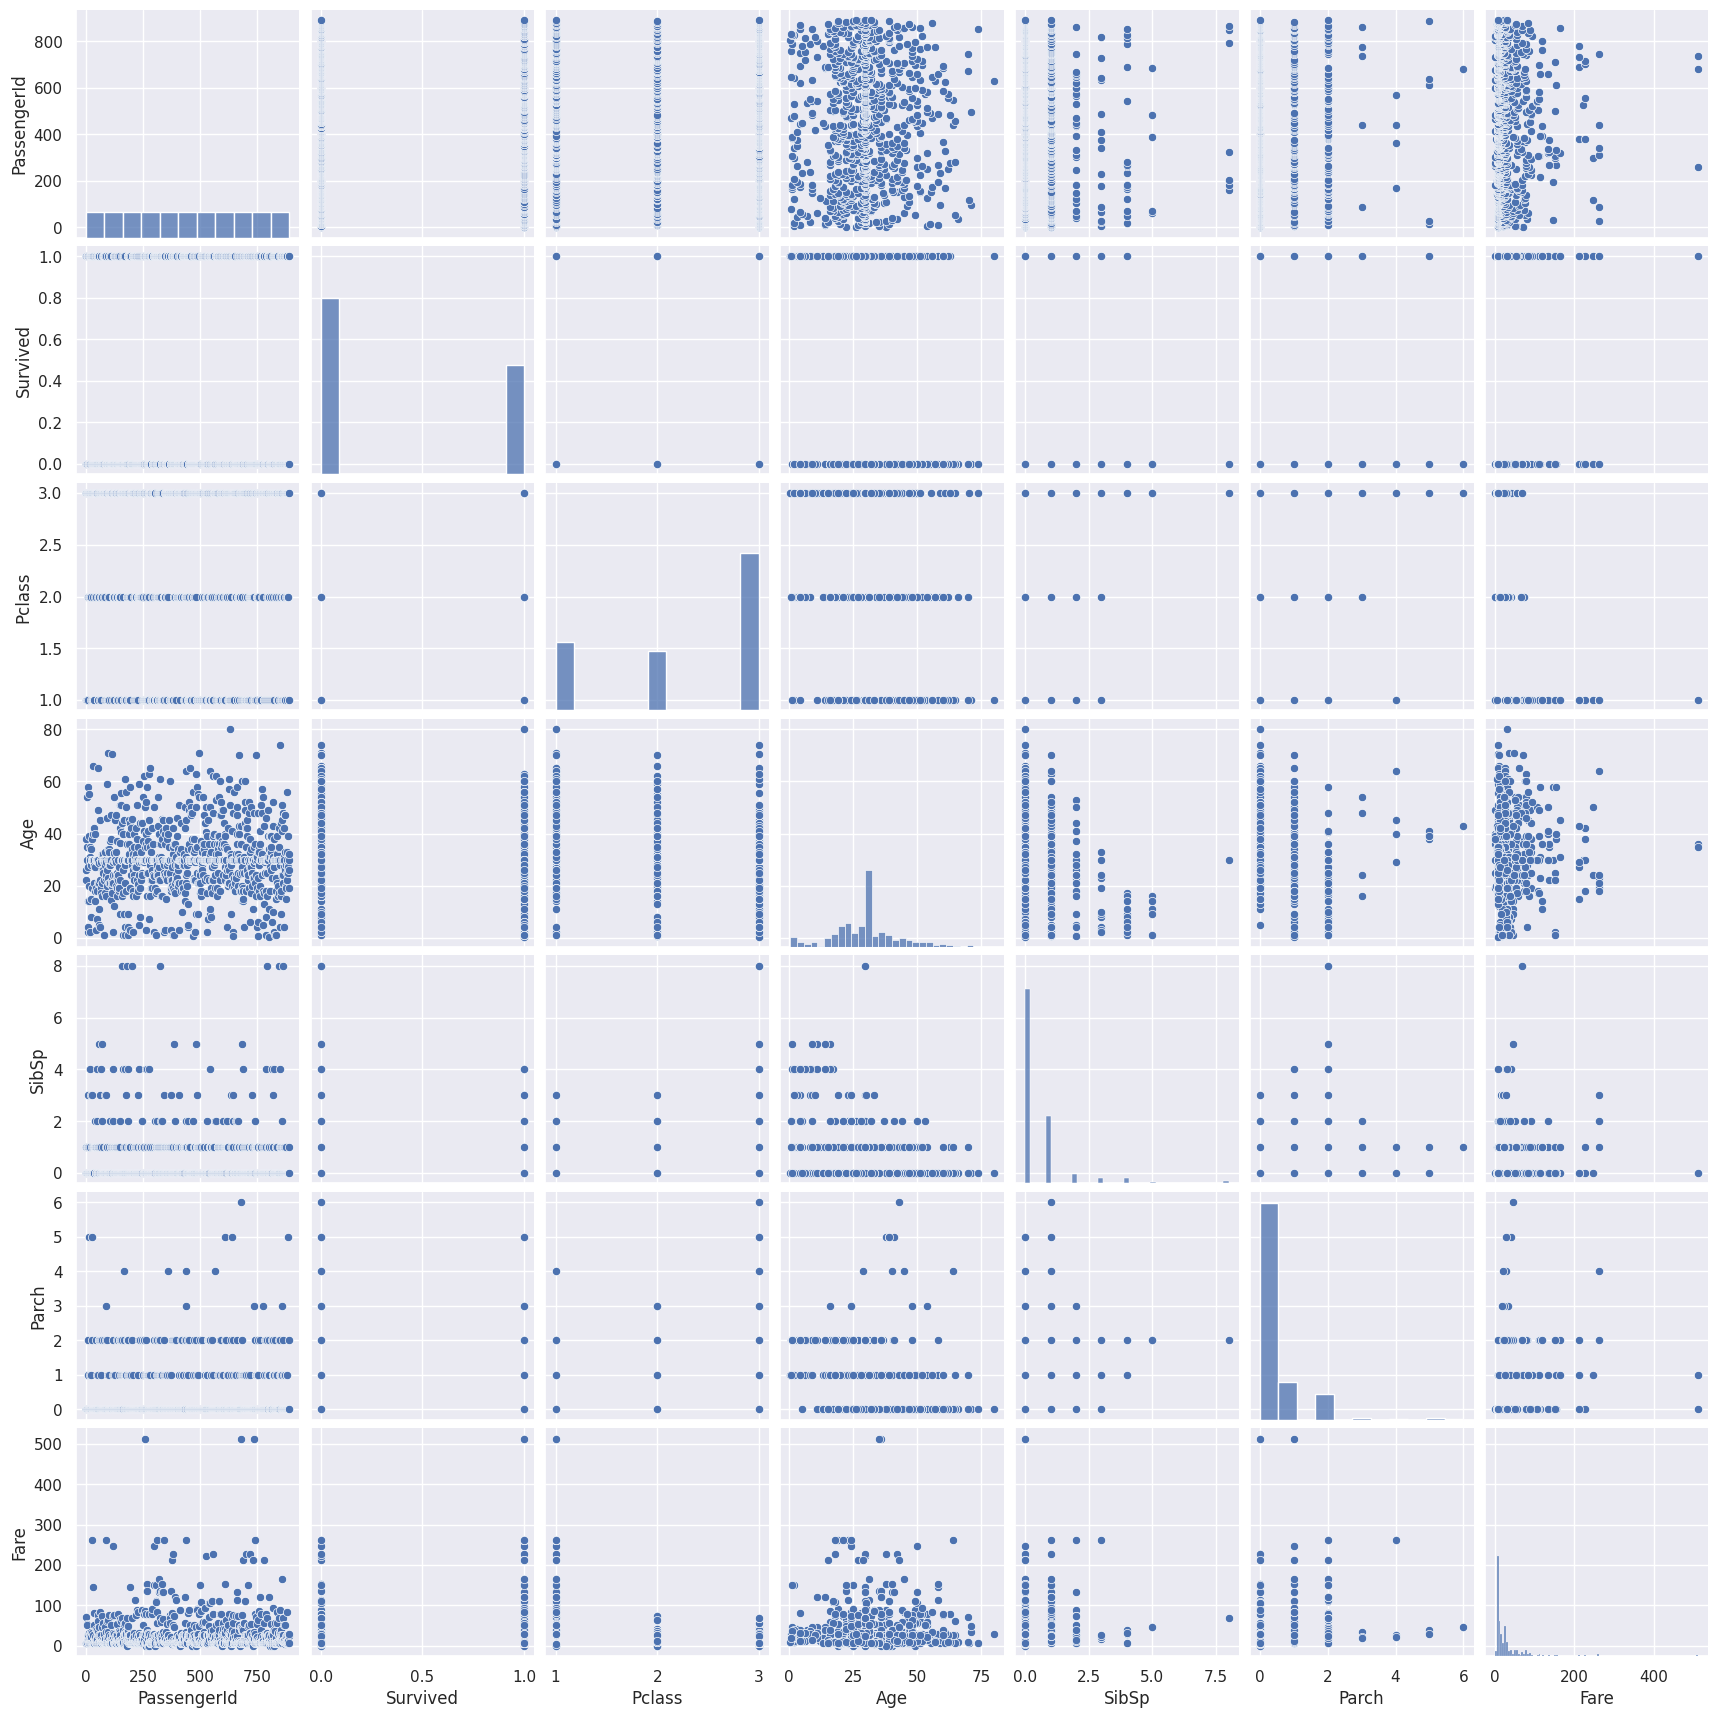

In [20]:
sns.set() # 히트맵 설정
sns.pairplot(df_train) # 데이터 분포 확인
plt.show()

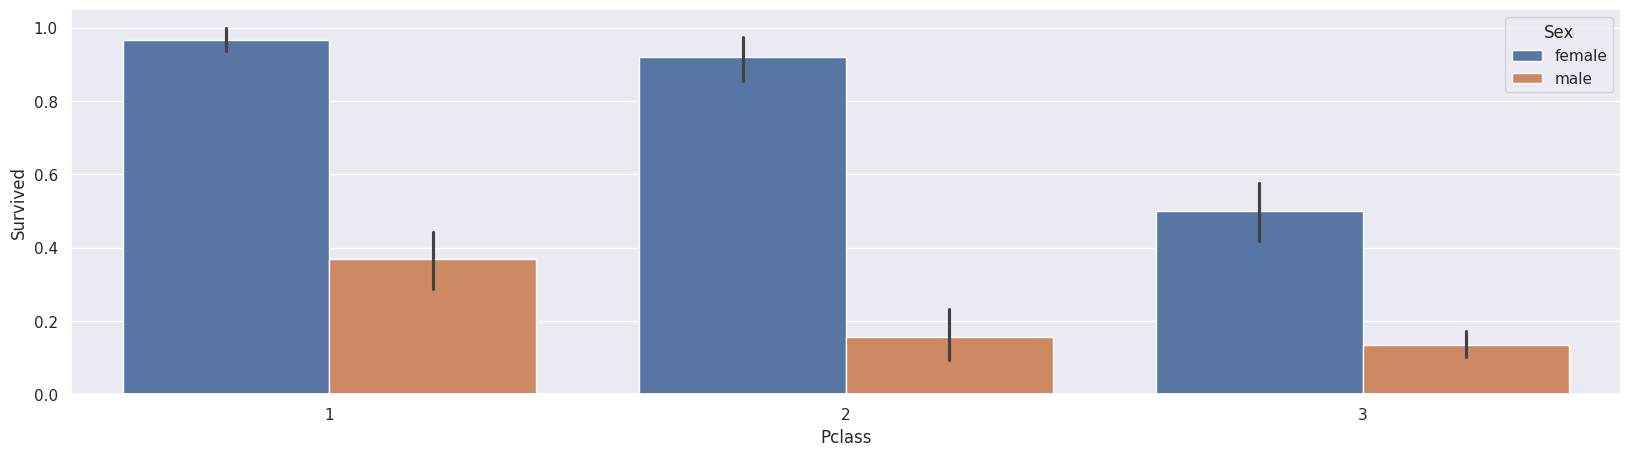

In [21]:
plt.figure(figsize=(20,5))
sns.barplot(x='Pclass',y='Survived', hue='Sex',data=df_train , estimator=np.mean) # 데이터 분포 확인
plt.show()

In [22]:
Pclas = pd.get_dummies(df_train['Pclass'],prefix='Pclass',drop_first=True) # 데이터 타입 변경
df_train = pd.concat([df_train,Pclas],axis=1) # 데이터 합치기

Embark = pd.get_dummies(df_train['Embarked'],prefix='Embarked',drop_first=True) # 데이터 타입 변경
df_train = pd.concat([df_train,Embark],axis=1) # 데이터 합치기

Sex = pd.get_dummies(df_train['Sex'],prefix='Sex',drop_first=True) # 데이터 타입 변경
df_train = pd.concat([df_train,Sex],axis=1) # 데이터 합치기

In [24]:
df_train = df_train.drop(['Embarked','Pclass','Sex'], axis = 1) # 불필요한 데이터 삭제

In [25]:
num_df_train = df_train[['Fare','Age']] # 데이터 분리
num_df_train.describe(percentiles=[.25,.5,.75,.90,.95,.99]) # 데이터 통계 확인

,Fare,Age
count,889.000000,889.000000
mean,32.096681,29.653446
std,49.697504,12.968366
min,0.000000,0.420000
25%,7.895800,22.000000
50%,14.454200,29.699118
75%,31.000000,35.000000
90%,77.287500,47.000000
95%,112.318320,54.000000
99%,249.303304,65.000000


In [26]:
round(100*(df_train.isnull().sum()/len(df_train.index)), 2) # 결측치 확인

,0
PassengerId,0.0
Survived,0.0
Age,0.0
SibSp,0.0
Parch,0.0
Fare,0.0
Pclass_2,0.0
Pclass_3,0.0
Embarked_Q,0.0
Embarked_S,0.0


In [27]:
df = df_train[['Fare','Age']] # 데이터 분리
df.shape  # 데이터 크기 확인

(889, 2)

In [29]:
normalized_df=(df-df.mean())/df.std() # 데이터 표준화
df_train = df_train.drop(['Fare','Age'], axis = 1) # 불필요한 데이터 삭제
df_train = pd.concat([df_train,normalized_df],axis=1) # 데이터 합치기
df_train # 데이터 확인

,PassengerId,Survived,SibSp,Parch,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male,Fare,Age
0,1,0,1,0,False,True,False,True,True,-0.499958,-0.590163
1,2,1,1,0,False,False,False,False,False,0.788503,0.643609
2,3,1,0,0,False,True,False,True,False,-0.486376,-0.281720
3,4,1,1,0,False,False,False,True,False,0.422623,0.412277
4,5,0,0,0,False,True,False,True,True,-0.483861,0.412277
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,0,0,True,False,False,True,True,-0.384258,-0.204609
887,888,1,0,0,False,False,False,True,False,-0.042189,-0.821495
888,889,0,1,2,False,True,False,True,False,-0.173986,0.003522
889,890,1,0,0,False,False,False,False,True,-0.042189,-0.281720


In [30]:
Survived = (sum(df_train['Survived'])/len(df_train['Survived'].index))*100 # 생존률 확인
Survived

38.24521934758155

In [31]:
from sklearn.model_selection import train_test_split

X = df_train.drop(['Survived','PassengerId'],axis=1) # 데이터 분리

y = df_train['Survived'] # 데이터 분리

y.head()

,Survived
0,0
1,1
2,1
3,1
4,0


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.6,test_size=0.4,random_state=100) # 데이터 분리

In [36]:
import statsmodels.api as sm
X_train = X_train.astype(int)
y_train = y_train.astype(int)
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial()) # 로지스틱 회귀 모델 생성
logm1.fit().summary() # 모델 요약

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Survived   No. Observations:                  533
Model:                            GLM   Df Residuals:                      523
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -234.37
Date:                Sun, 29 Jun 2025   Deviance:                       468.74
Time:                        06:10:40   Pearson chi2:                     616.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3621
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9569      0.394      7.505      0.000       2.185       3.729
SibSp         -0.2933      0.134     -2.184      0.029      -0.556      -0.030
Parch          0.0061      0.168      0.036      0.971      -0.323       0.335
Pclass_2      -1.1381      0.356     -3.194      0.001      -1.837      -0.440
Pclass_3      -2.3420      0.333     -7.023      0.000      -2.996      -1.688
Embarked_Q    -0.2697      0.543     -0.497      0.619      -1.334       0.795
Embarked_S    -0.2259      0.303     -0.745      0.456      -0.820       0.368
Sex_male      -2.7252      0.261    -10.441      0.000      -3.237      -2.214
Fare           0.0184      0.161      0.114      0.909      -0.297       0.334
Age           -0.9121      0.183     -4.978      0.000      -1.271      -0.553
==============================================================================
"""

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<Axes: >

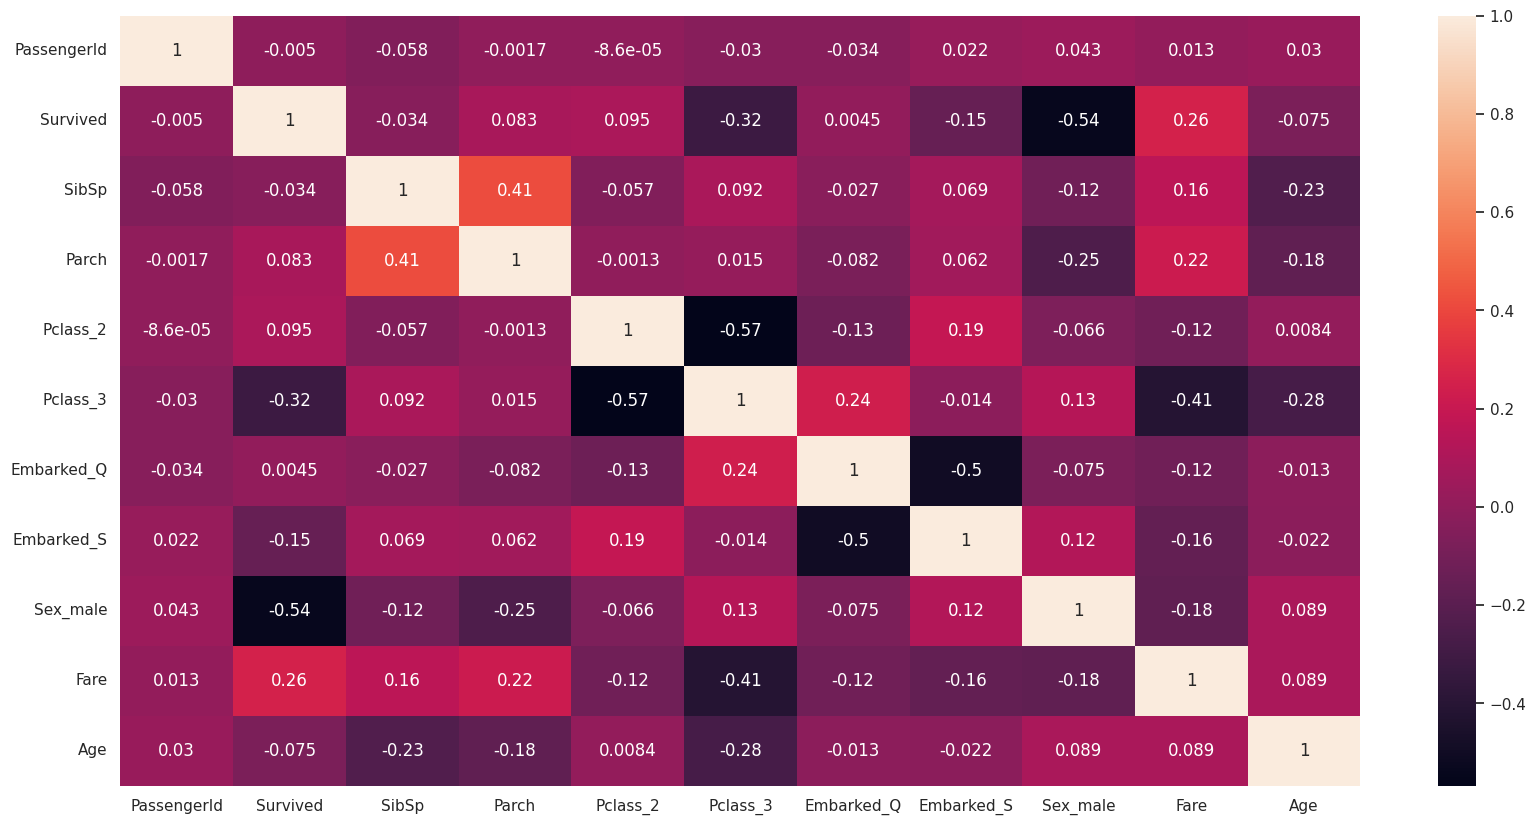

In [38]:
plt.figure(figsize = (20,10))
sns.heatmap(df_train.corr(),annot = True) # 상관관계 히트맵 확인

In [40]:
X_test2 = X_test.drop(['Embarked_Q','Pclass_2'],axis = 1) # 불필요한 데이터 삭제
X_train2 = X_train.drop(['Embarked_Q','Pclass_2'],axis = 1) # 불필요한 데이터 삭제

<Axes: >

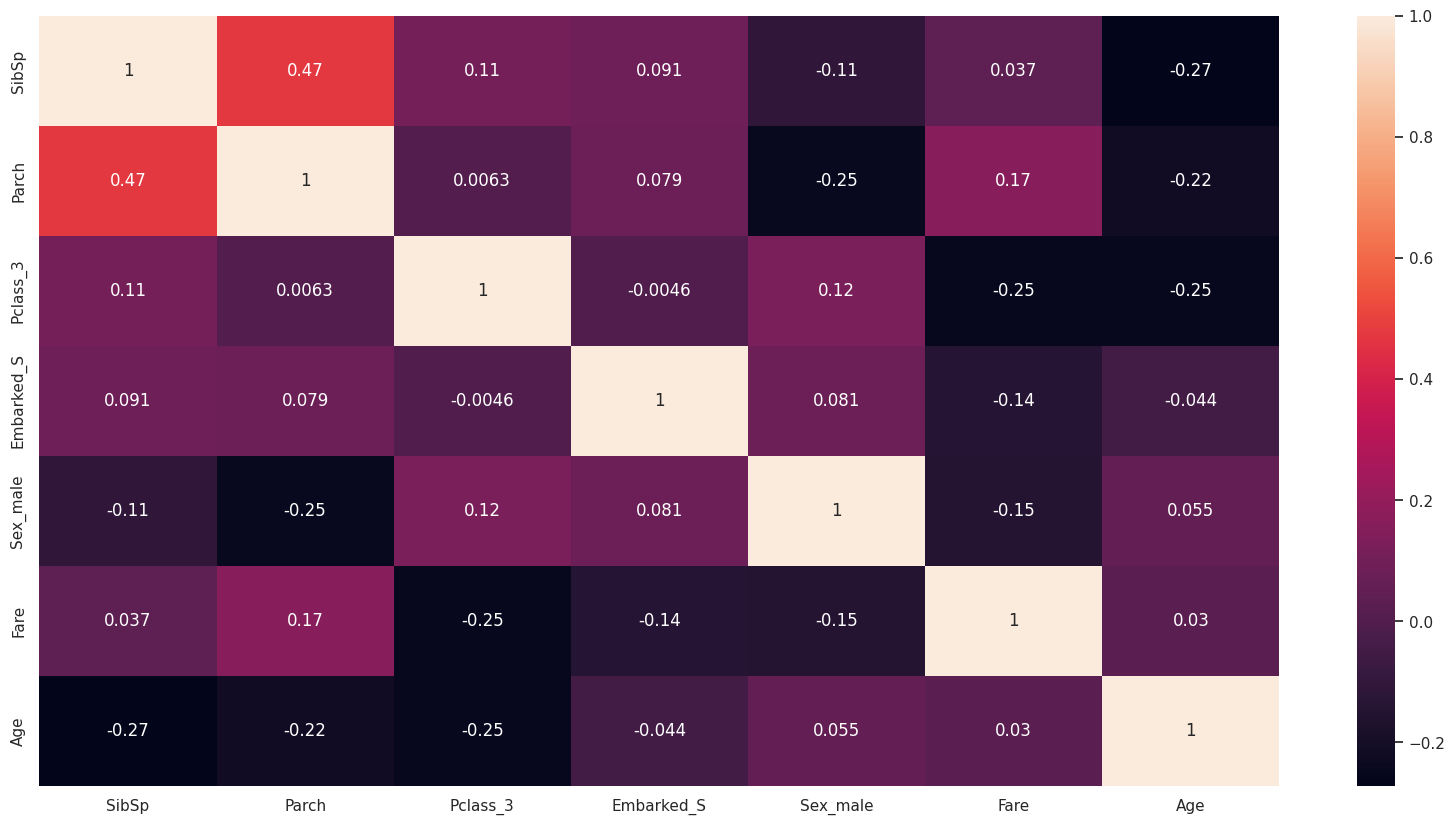

In [41]:
plt.figure(figsize = (20,10))
sns.heatmap(X_train2.corr(),annot = True) # 상관관계 히트맵 확인

In [42]:
logm2 = sm.GLM(y_train,(sm.add_constant(X_train2)), family = sm.families.Binomial()) # 로지스틱 회귀 모델 생성
logm2.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Survived   No. Observations:                  533
Model:                            GLM   Df Residuals:                      525
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -240.00
Date:                Sun, 29 Jun 2025   Deviance:                       479.99
Time:                        06:11:31   Pearson chi2:                     576.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3485
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3611      0.327      7.224      0.000       1.721       3.002
SibSp         -0.2532      0.130     -1.945      0.052      -0.508       0.002
Parch         -0.0056      0.165     -0.034      0.973      -0.329       0.318
Pclass_3      -1.7535      0.254     -6.901      0.000      -2.252      -1.255
Embarked_S    -0.3398      0.259     -1.314      0.189      -0.847       0.167
Sex_male      -2.6149      0.252    -10.367      0.000      -3.109      -2.121
Fare           0.1646      0.165      0.995      0.319      -0.160       0.489
Age           -0.7676      0.175     -4.396      0.000      -1.110      -0.425
==============================================================================
"""

In [43]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
from sklearn.feature_selection import RFE
rfe = RFE(logreg) # 변수 선택
rfe = rfe.fit(X,y)  # 변수 선택
print(rfe.support_) # 변수 선택 확인
print(rfe.ranking_) # 변수 선택 확인

[False False  True  True False  True  True False False]
[3 5 1 1 6 1 1 4 2]


In [44]:
col = ['Sex_male','Pclass_3', 'Fare','Age','Embarked_S','Parch'] # 변수 선택

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logsk = LogisticRegression(C=1e9) # 로지스틱 회귀 모델 생성
logsk.fit(X_train, y_train) # 모델 생성

LogisticRegression(C=1000000000.0)

In [46]:
logm4 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial()) # 로지스틱 회귀 모델 생성
modres = logm4.fit() # 모델 생성
logm4.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Survived   No. Observations:                  533
Model:                            GLM   Df Residuals:                      523
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -234.37
Date:                Sun, 29 Jun 2025   Deviance:                       468.74
Time:                        06:12:01   Pearson chi2:                     616.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3621
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9569      0.394      7.505      0.000       2.185       3.729
SibSp         -0.2933      0.134     -2.184      0.029      -0.556      -0.030
Parch          0.0061      0.168      0.036      0.971      -0.323       0.335
Pclass_2      -1.1381      0.356     -3.194      0.001      -1.837      -0.440
Pclass_3      -2.3420      0.333     -7.023      0.000      -2.996      -1.688
Embarked_Q    -0.2697      0.543     -0.497      0.619      -1.334       0.795
Embarked_S    -0.2259      0.303     -0.745      0.456      -0.820       0.368
Sex_male      -2.7252      0.261    -10.441      0.000      -3.237      -2.214
Fare           0.0184      0.161      0.114      0.909      -0.297       0.334
Age           -0.9121      0.183     -4.978      0.000      -1.271      -0.553
==============================================================================
"""

In [47]:
X_test[col].shape

(356, 6)

In [48]:
y_pred = logsk.predict_proba(X_test) # 예측
y_pred_df = pd.DataFrame(y_pred)
y_pred_1 = y_pred_df.iloc[:,[1]]
y_pred_1

,1
0,0.066666
1,0.780651
2,0.123965
3,0.571877
4,0.124865
...,...
351,0.689020
352,0.038617
353,0.709502
354,0.968858


In [49]:
y_test_df = pd.DataFrame(y_test)
y_test_df

,Survived
639,0
147,0
278,0
484,1
770,0
...,...
272,1
699,0
813,0
291,1


In [50]:
y_test_df['PassengerId'] = y_test_df.index # 데이터 합치기
y_pred_1.reset_index(drop=True, inplace=True) # 데이터 합치기
y_test_df.reset_index(drop=True, inplace=True) # 데이터 합치기
y_pred_final = pd.concat([y_test_df,y_pred_1],axis=1) # 데이터 합치기
y_pred_final= y_pred_final.rename(columns={ 1 : 'Survived_Prob'}) # 데이터 합치기
y_pred_final = y_pred_final.reindex(['PassengerId','Survived','Survived_Prob'], axis=1) # 데이터 합치기
y_pred_final.head()

,PassengerId,Survived,Survived_Prob
0,639,0,0.066666
1,147,0,0.780651
2,278,0,0.123965
3,484,1,0.571877
4,770,0,0.124865


In [51]:
y_pred_final['predicted'] = y_pred_final.Survived_Prob.map( lambda x: 1 if x > 0.5 else 0) # 예측값 생성

y_pred_final.head()

,PassengerId,Survived,Survived_Prob,predicted
0,639,0,0.066666,0
1,147,0,0.780651,1
2,278,0,0.123965,0
3,484,1,0.571877,1
4,770,0,0.124865,0


In [52]:
from sklearn import metrics
confusion = metrics.confusion_matrix( y_pred_final.Survived, y_pred_final.predicted ) # 혼동행렬 생성
confusion

array([[186,  33],
       [ 36, 101]])

In [53]:
metrics.accuracy_score(y_pred_final.Survived, y_pred_final.predicted) # 정확도 확인

0.8061797752808989

In [54]:
def draw_roc( actual, probs ): # ROC 곡선 생성
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs, drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, thresholds

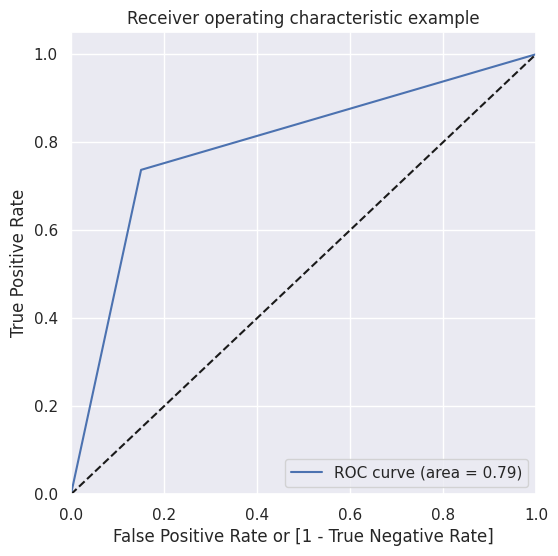

(array([0.        , 0.15068493, 1.        ]),
 array([0.        , 0.73722628, 1.        ]),
 array([inf,  1.,  0.]))

In [55]:
draw_roc(y_pred_final.Survived, y_pred_final.predicted) # ROC 곡선 확인

In [56]:
"{:2.2f}".format(metrics.roc_auc_score(y_pred_final.Survived, y_pred_final.Survived_Prob)) # AUC 확인

'0.85'

In [57]:
X_train.shape

(533, 9)

In [60]:
from sklearn.decomposition import PCA
pca = PCA(random_state=42) # PCA 생성

In [61]:
pca.fit(X_train) # PCA 생성

PCA(random_state=42)

In [62]:
pca.components_ # PCA 생성

array([[ 0.86819914,  0.41247448, -0.02194047,  0.05155467, -0.00727957,
         0.03512709, -0.06907146,  0.07057486, -0.24883169],
       [-0.11567077,  0.23052118, -0.01203447, -0.24630974, -0.02370173,
        -0.0918801 , -0.1391288 ,  0.89484511,  0.20870702],
       [ 0.34951183, -0.14079613,  0.03603915, -0.18233252, -0.01851478,
         0.03581518,  0.05027768, -0.16483301,  0.89002847],
       [-0.31451638,  0.7944661 ,  0.19890573, -0.16690351, -0.0688813 ,
         0.14211779, -0.19830603, -0.34112401,  0.14781683],
       [-0.0976006 ,  0.2761912 , -0.57314656,  0.65959778,  0.13835362,
        -0.25167337,  0.06034832,  0.01820659,  0.25332138],
       [-0.04430132,  0.13351377, -0.02592718,  0.1071345 , -0.21668048,
         0.59281465,  0.73855898,  0.15431147,  0.02001014],
       [-0.00466528, -0.17595139, -0.13792945,  0.27742996, -0.15802335,
         0.67528131, -0.61916614,  0.07531594,  0.0548818 ],
       [ 0.00902665,  0.00319391,  0.74467379,  0.52767562,  0

In [63]:
pca.explained_variance_ratio_ # PCA 생성

array([0.39677982, 0.1811393 , 0.12478198, 0.09905615, 0.07508928,
       0.05454574, 0.04175432, 0.01716757, 0.00968585])

In [64]:
var_cumu = np.cumsum(pca.explained_variance_ratio_) # PCA 생성

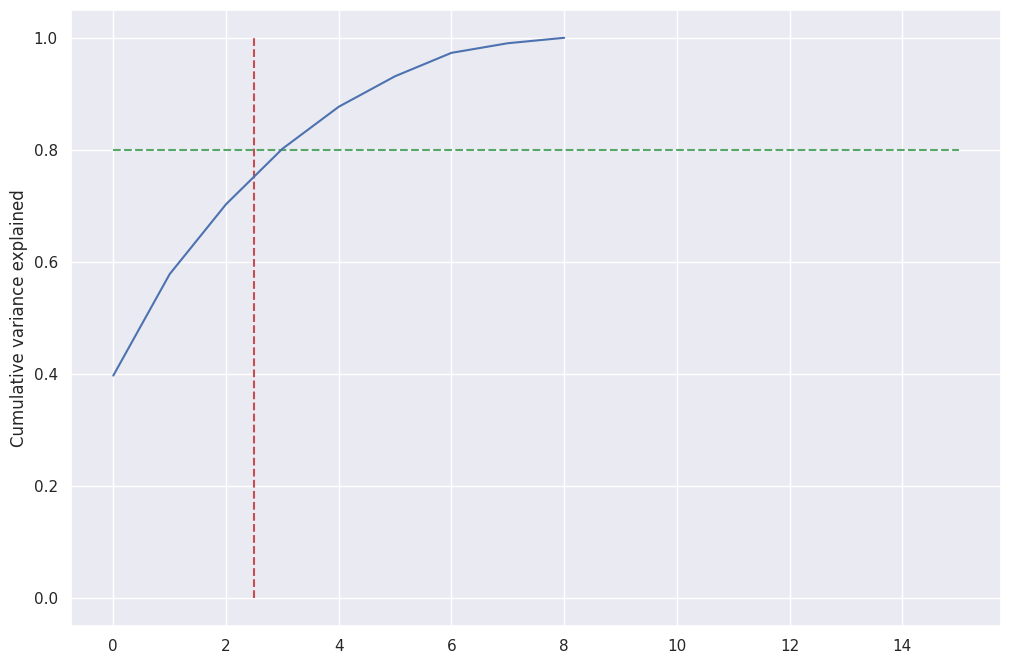

In [65]:
fig = plt.figure(figsize=[12,8])
plt.vlines(x=2.5, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.8, xmax=15, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()

In [66]:
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=6) # PCA 생성
df_train_pca = pca_final.fit_transform(X_train) # PCA 생성

In [67]:
df_train_pca.shape

(533, 6)

In [69]:
corrmat = np.corrcoef(df_train_pca.transpose()) # PCA 생성
corrmat.shape

(6, 6)

In [70]:
df_test_pca = pca_final.transform(X_test) # PCA 생성
df_test_pca.shape

(356, 6)

In [73]:
from sklearn.linear_model import LogisticRegression
learner_pca = LogisticRegression() # 로지스틱 회귀 모델 생성
model_pca = learner_pca.fit(df_train_pca, y_train) # 로지스틱 회귀 모델 생성

In [74]:
pred_probs_test = model_pca.predict_proba(df_test_pca) # 예측

In [75]:
"{:2.2}".format(metrics.roc_auc_score(y_test, pred_probs_test[:,1])) # AUC 확인

'0.81'

In [76]:
pca_again = PCA(0.9) # PCA 생성

In [111]:
X_train.shape

(533, 9)

In [77]:
df_train_pca2 = pca_again.fit_transform(X_train) # PCA 생성

In [78]:
df_train_pca2.shape # PCA 생성

(533, 6)

In [112]:
learner_pca2 = LogisticRegression() # 로지스틱 회귀 모델 생성
model_pca2 = learner_pca2.fit(df_train_pca2, y_train) # 로지스틱 회귀 모델 생성

In [80]:
df_test_pca2 = pca_again.transform(X_test) # PCA 생성

In [81]:
df_test_pca2.shape # PCA 생성

(356, 6)

In [82]:
pred_probs_test2 = model_pca2.predict_proba(df_test_pca2)[:,1] # 예측

In [83]:
"{:2.2}".format(metrics.roc_auc_score(y_test, pred_probs_test2)) # AUC 확인

'0.84'

In [110]:
pred_probs_test2.shape

(356,)

In [84]:
df_test['Survived'] = df_test['Survived'].apply(str) # 데이터 타입 변경
df_test['Pclass'] = df_test['Pclass'].apply(str) # 데이터 타입 변경

In [85]:
final_test = pd.get_dummies(df_test,columns=["Sex"]) # 원핫인코딩
final_test.drop('Sex_female', axis = 1, inplace=True) # 원핫인코딩
final_test

,PassengerId,Pclass,Name,Age,SibSp,Parch,Fare,Embarked,Survived,Sex_male
0,892,3,"Kelly, Mr. James",34.50000,0,0,7.8292,Q,0,True
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",47.00000,1,0,7.0000,S,1,False
2,894,2,"Myles, Mr. Thomas Francis",62.00000,0,0,9.6875,Q,0,True
3,895,3,"Wirz, Mr. Albert",27.00000,0,0,8.6625,S,0,True
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",22.00000,1,1,12.2875,S,1,False
...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",30.27259,0,0,8.0500,S,0,True
414,1306,1,"Oliva y Ocana, Dona. Fermina",39.00000,0,0,108.9000,C,1,False
415,1307,3,"Saether, Mr. Simon Sivertsen",38.50000,0,0,7.2500,S,0,True
416,1308,3,"Ware, Mr. Frederick",30.27259,0,0,8.0500,S,0,True


In [86]:
final_test = pd.get_dummies(final_test,columns=["Embarked"]) # 원핫인코딩
final_test.drop('Embarked_C', axis = 1, inplace=True) # 원핫인코딩
final_test

,PassengerId,Pclass,Name,Age,SibSp,Parch,Fare,Survived,Sex_male,Embarked_Q,Embarked_S
0,892,3,"Kelly, Mr. James",34.50000,0,0,7.8292,0,True,True,False
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",47.00000,1,0,7.0000,1,False,False,True
2,894,2,"Myles, Mr. Thomas Francis",62.00000,0,0,9.6875,0,True,True,False
3,895,3,"Wirz, Mr. Albert",27.00000,0,0,8.6625,0,True,False,True
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",22.00000,1,1,12.2875,1,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",30.27259,0,0,8.0500,0,True,False,True
414,1306,1,"Oliva y Ocana, Dona. Fermina",39.00000,0,0,108.9000,1,False,False,False
415,1307,3,"Saether, Mr. Simon Sivertsen",38.50000,0,0,7.2500,0,True,False,True
416,1308,3,"Ware, Mr. Frederick",30.27259,0,0,8.0500,0,True,False,True


In [87]:
y_test = final_test.pop("Survived")
print(y_test)

0      0
1      1
2      0
3      0
4      1
      ..
413    0
414    1
415    0
416    0
417    0
Name: Survived, Length: 418, dtype: object


In [88]:
final_test

,PassengerId,Pclass,Name,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,892,3,"Kelly, Mr. James",34.50000,0,0,7.8292,True,True,False
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",47.00000,1,0,7.0000,False,False,True
2,894,2,"Myles, Mr. Thomas Francis",62.00000,0,0,9.6875,True,True,False
3,895,3,"Wirz, Mr. Albert",27.00000,0,0,8.6625,True,False,True
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",22.00000,1,1,12.2875,False,False,True
...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",30.27259,0,0,8.0500,True,False,True
414,1306,1,"Oliva y Ocana, Dona. Fermina",39.00000,0,0,108.9000,False,False,False
415,1307,3,"Saether, Mr. Simon Sivertsen",38.50000,0,0,7.2500,True,False,True
416,1308,3,"Ware, Mr. Frederick",30.27259,0,0,8.0500,True,False,True


In [89]:
import re
import warnings
import io
import requests

url="https://github.com/thisisjasonjafari/my-datascientise-handcode/raw/master/005-datavisualization/titanic.csv" # 데이터 불러오기
s=requests.get(url).content # 데이터 불러오기
c=pd.read_csv(io.StringIO(s.decode('utf-8'))) # 데이터 불러오기

test_data_with_labels = c # 데이터 불러오기

In [104]:
for i, name in enumerate(test_data_with_labels['name']): # 이름에서 호칭 추출
    if '"' in name:
        test_data_with_labels['name'][i] = re.sub('"', '', name)

for i, name in enumerate(df_test['Name']): # 이름에서 호칭 추출
    if '"' in name:
        df_test['Name'][i] = re.sub('"', '', name)

survived = []

for name in df_test['Name']: # 이름에서 호칭 추출
    survived.append(int(test_data_with_labels.loc[test_data_with_labels['name'] == name]['survived'].values[-1]))

In [105]:
test_y = pd.read_csv(colab_path + 'titanic/titanic_gender_submission.csv')
test_y = test_y.drop(['PassengerId'], axis = 1) # 불필요한 데이터 삭제
pred_y = test_y
pred_y['Survived'] = survived
#submission.to_csv(colab_path + 'titanic/submission_pca.csv', index=False)

In [108]:
test_y

,Survived
0,0
1,1
2,0
3,0
4,1
...,...
413,0
414,1
415,0
416,0


In [ ]:
# from sklearn.metrics import precision_score, recall_score, f1_score

# # 예측 결과: test_y (정답), pred_y (모델 예측값)
# precision = precision_score(test_y, pred_y)
# recall = recall_score(test_y, pred_y)
# f1 = f1_score(test_y, pred_y)

# print(f'Precision: {precision:.4f}')
# print(f'Recall:    {recall:.4f}')
# print(f'F1 Score:  {f1:.4f}')